In [1]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
#plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
#plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap as pch
print(pch.__version__)

import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import scanpy as sc
import glob

1.8.2


In [2]:
print("Scanpy version:", sc.__version__)

Scanpy version: 1.10.4


In [3]:
adata_all = sc.read_h5ad('/home/junyichen/code/scmmd/output/atac0627/3REGIONS_gene.h5ad')


In [4]:
l2meta_name = '/data2st1/junyi/output/atac0627/ATACSC_3REGION_ALL_L2annoated.csv'

if not os.path.exists(l2meta_name):
    print(f"File {l2meta_name} does not exist. Please check the path.")
    adata_sc = sc.read_h5ad("/data1st1/sch/20250626/anndata_before_intergration_anno.h5ad")


File /data2st1/junyi/output/atac0627/ATACSC_3REGION_ALL_L2annoated.csv does not exist. Please check the path.


In [5]:
df_ct_nt = adata_sc.obs.loc[:,['Neurotransmitter_celltype','celltype.L1','celltype.L2']].drop_duplicates(subset='celltype.L2')

In [6]:
df_ct_nt['Neurotransmitter_celltype'] = df_ct_nt['Neurotransmitter_celltype'].fillna('NN')

In [7]:
f_l2annos = glob.glob('/data2st1/junyi/output/atac0627/ATACSC_*_L2annoated.csv')

In [8]:
meta_atac = pd.DataFrame()
for f in f_l2annos:
    df = pd.read_csv(f,index_col=0)
    meta_atac = pd.concat([meta_atac,df],axis=0)

In [9]:
meta_atac.index = meta_atac.index.str.replace('_query','',regex=False)

In [10]:
diff_cells = list(set(adata_all.obs.index).difference(set(meta_atac.index)))

In [73]:
df_l2_nt = dict(zip(df_ct_nt['celltype.L2'],df_ct_nt['Neurotransmitter_celltype'])) 
df_l2_l1 = dict(zip(df_ct_nt['celltype.L2'],df_ct_nt['celltype.L1']))

In [11]:
meta_atac_merged = meta_atac.merge(df_ct_nt,how='left',left_on='celltype.L2',right_on='celltype.L2',suffixes=('', '_ct'))

In [12]:
meta_atac_merged.index = meta_atac.index

In [13]:
nnmeta = meta_atac_merged[meta_atac_merged['Neurotransmitter_celltype']=='NN']

In [14]:
adata_nn = adata_all[nnmeta.index]

In [15]:
adata_nn.obs['celltype.L2'] = nnmeta['celltype.L2'].values


/tmp/ipykernel_90907/2709870114.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nn.obs['celltype.L2'] = nnmeta['celltype.L2'].values


In [16]:
adata_nn.obs['celltype.L1_ct'] = nnmeta['celltype.L1_ct'].values

In [17]:
adata_nn.obs['equal'] =True
adata_nn.obs.loc[adata_nn.obs['celltype.L1'].astype(str) != adata_nn.obs['celltype.L1_ct'].astype(str),'equal'] = False

In [18]:
adata_nn.obs.loc[adata_nn.obs['celltype.L1'].astype(str) != adata_nn.obs['celltype.L1_ct'].astype(str)]

,sample,doublet_probability,doublet_score,leiden,leiden_default,leiden_res_0.1,leiden_res_0.2,leiden_res_0.3,leiden_res_0.4,leiden_res_0.5,...,leiden_res_1.4,leiden_res_1.5,leiden_res_1.6,leiden_res_1.7,leiden_res_1.8,leiden_res_1.9,celltype.L1,celltype.L2,celltype.L1_ct,equal
MC37A_AMY:AAACTGCAGGTTCGTT-1,MC37A_AMY,0.200594,0.177331,18,7,4,5,5,6,7,...,6,18,18,18,18,18,Immune,Endothelial cell-3,Vascular,False
MC37A_AMY:AACGTACCATTGTTCT-1,MC37A_AMY,0.153818,0.003883,10,10,5,6,6,7,8,...,9,9,11,11,9,10,Astro-Epen,Endothelial cell-1,Vascular,False
MC37A_AMY:AATGTCGAGAAGCCTG-1,MC37A_AMY,0.147933,0.006024,10,10,5,6,6,7,8,...,9,9,11,11,9,10,Astro-Epen,COP,OPC-Oligo,False
MC37A_AMY:ACAAGCTAGGTTCGTT-1,MC37A_AMY,0.128610,0.014116,14,13,6,7,7,8,10,...,15,15,14,13,14,14,OPC-Oligo,Endothelial cell-1,Vascular,False
MC37A_AMY:ACAGGCCAGTACCTCA-1,MC37A_AMY,0.174080,0.170213,18,7,4,5,5,6,7,...,6,18,18,18,18,18,Immune,MOL-1,OPC-Oligo,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MW51A_HIP:TTACTCACATCCGTGG-1,MW51A_HIP,0.061920,0.046196,21,10,5,6,6,7,8,...,9,9,20,20,21,21,Vascular,Choroid plexus cell,Astro-Epen,False
MW51A_HIP:TTAGGTGAGTTGTCCA-1,MW51A_HIP,0.098691,0.010282,21,10,5,6,6,7,8,...,9,9,20,20,21,21,Vascular,Choroid plexus cell,Astro-Epen,False
MW51A_HIP:TTCATTGCATCCCAAA-1,MW51A_HIP,0.064898,0.040462,21,10,5,6,6,7,8,...,9,9,20,20,21,21,Vascular,Microglia-3,Immune,False
MW51A_HIP:TTCGGTCGTCTTAGCA-1,MW51A_HIP,0.074265,0.107759,21,10,5,6,6,7,8,...,9,9,20,20,21,21,Vascular,Choroid plexus cell,Astro-Epen,False


[<Axes: title={'center': 'celltype.L1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype.L1_ct'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden_res_1.9'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype.L2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'equal'}, xlabel='UMAP1', ylabel='UMAP2'>]

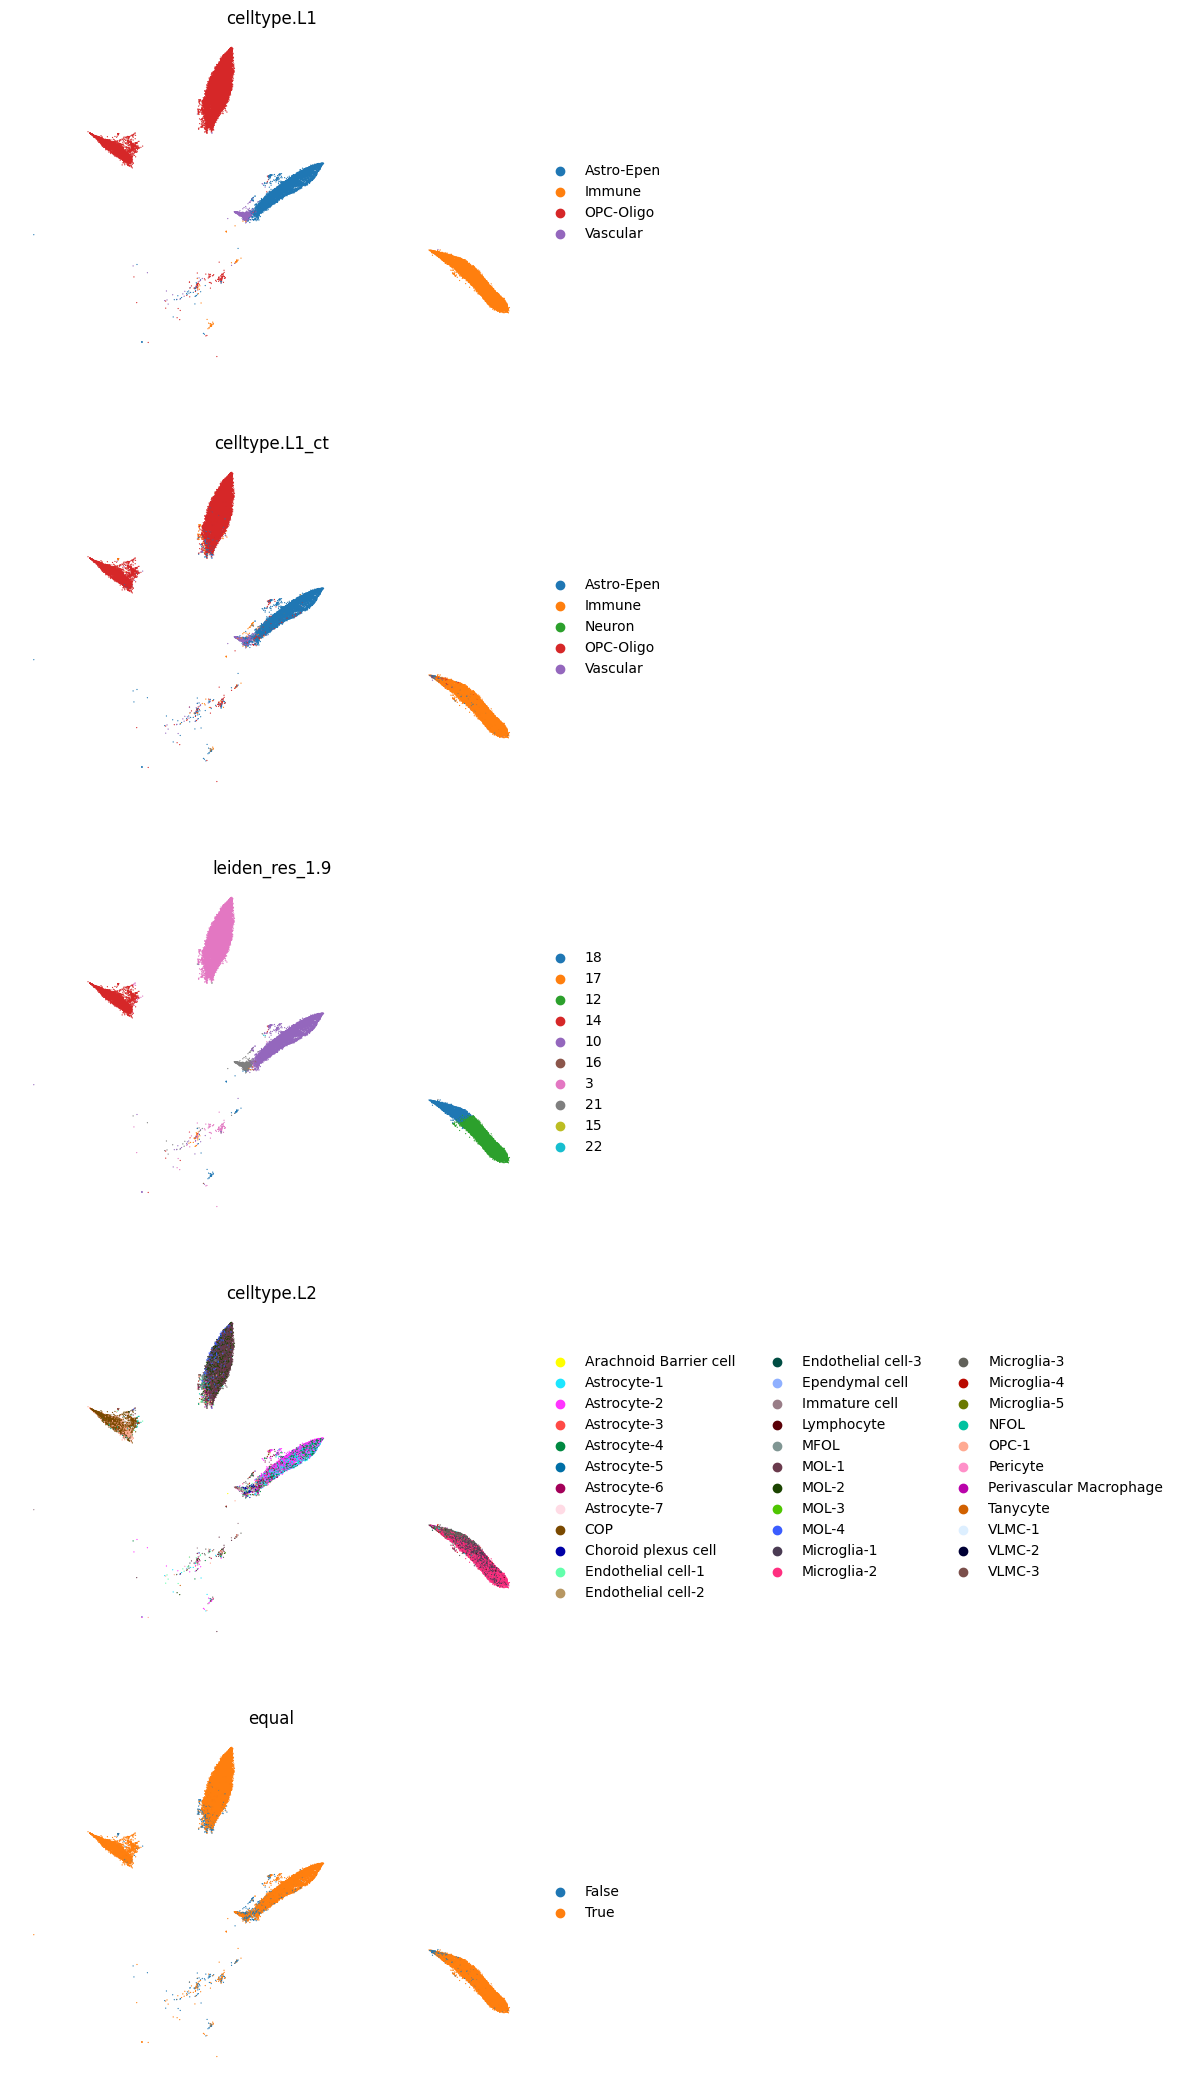

In [20]:
sc.pl.umap(adata_nn,color=['celltype.L1','celltype.L1_ct','leiden_res_1.9','celltype.L2','equal'],ncols=1,frameon=False,show=False)

In [21]:
adata_neuron = adata_all[adata_all.obs['celltype.L1']=='Neuron']

In [22]:
#​1. GABAergic Neuron Markers​ and ​2. Glutamatergic Neuron Markers​
marker_genes_dict = {
    "GABA": ["Slc32a1", "Gad1", "Gad2", "Gabrb3", "Gabra2", "Gabrb2", "Gabrb1", "Gabrq", "Gabrp"],
    "Glutamate": ["Slc17a7", "Slc17a6", "Slc17a8", "Slc17a9", "Grin1", "Grin2a", "Grin2b", "Grin2c", "Grin2d", "Gria1", "Gria2", "Gria3"]
}


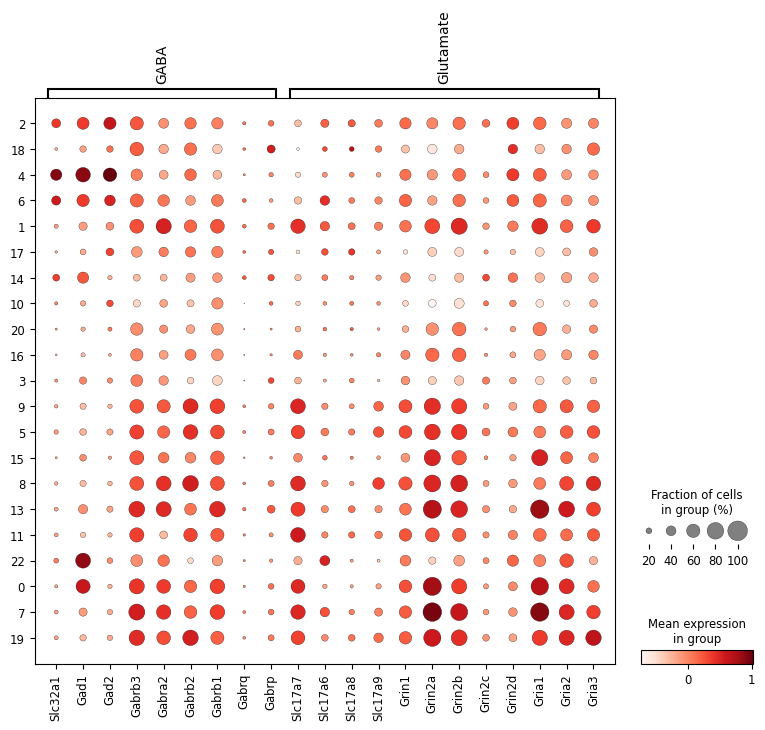

In [23]:
sc.pl.dotplot(adata_neuron, marker_genes_dict, "leiden_res_"+str(1.9), dendrogram=False)


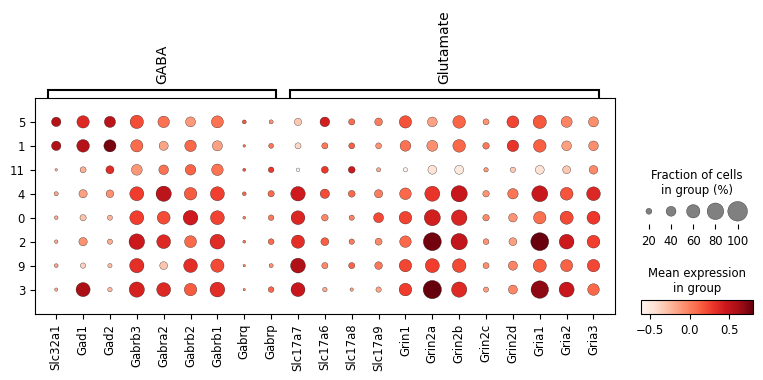

In [24]:
sc.pl.dotplot(adata_neuron, marker_genes_dict, "leiden_res_"+str(0.5), dendrogram=False)


In [28]:
meta_atac_merged

,sample,doublet_score,leiden,celltype.L1,celltype.L2,batch,n_genes,Neurotransmitter_celltype,celltype.L1_ct
MC37A_AMY:AAACGAAAGGGTAGTC-1,MC37A_AMY,0.014116,0,Immune,Microglia-3,query,4104,NN,Immune
MC37A_AMY:AAACTCGAGGATTAAC-1,MC37A_AMY,0.024516,0,Immune,Microglia-2,query,6580,NN,Immune
MC37A_AMY:AAACTCGAGGCCAATG-1,MC37A_AMY,0.059578,3,OPC-Oligo,OPC-1,query,4595,NN,OPC-Oligo
MC37A_AMY:AAACTCGCATGCACTA-1,MC37A_AMY,0.069583,4,Astro-Epen,Astrocyte-1,query,5006,NN,Astro-Epen
MC37A_AMY:AAACTGCAGGTTCGTT-1,MC37A_AMY,0.177331,7,Immune,Endothelial cell-3,query,7208,NN,Vascular
...,...,...,...,...,...,...,...,...,...
MW65A_AMY:TTTGTGTGTGCAAGCA-1,MW65A_AMY,0.025641,2,Neuron,AMY Vgll3_Pde11a Glut,query,8298,Glutamatergic,Neuron
MW65A_AMY:TTTGTGTGTTCCTGTC-1,MW65A_AMY,0.008648,3,Neuron,AMY Rai14_Six3 GABA,query,4375,GABAergic,Neuron
MW65A_AMY:TTTGTGTTCAACGTGT-1,MW65A_AMY,0.026467,3,Neuron,AMY Foxp2_Penk GABA,query,7650,GABAergic,Neuron
MW65A_AMY:TTTGTGTTCATACTTC-1,MW65A_AMY,0.013699,23,Neuron,AMY Maf_Pthlh GABA,query,5052,GABAergic,Neuron


In [36]:
merged_df = adata_all.obs.merge(meta_atac_merged[['celltype.L2','Neurotransmitter_celltype','celltype.L1_ct']], left_index=True, right_index=True, suffixes=('', '_meta'),how='left')

In [ ]:
df_missing = merged_df[merged_df.isna().any(axis=1)]

In [77]:
# Process missing with leiden largest group

In [ ]:
for index, row in df_missing.iterrows():
    sample_name = row['sample']
    leiden_row = row['leiden_res_1.9']
    subset_sample= merged_df[(merged_df['sample'] == sample_name) & (merged_df['leiden_res_1.9'] == leiden_row)]
    top_celltype = subset_sample['celltype.L2'].value_counts().idxmax()
    nt_type = df_l2_nt[top_celltype]
    l1_type = df_l2_l1[top_celltype]
    merged_df.at[index, 'celltype.L2'] = top_celltype
    merged_df.at[index, 'Neurotransmitter_celltype'] = nt_type
    merged_df.at[index, 'celltype.L1_ct'] = l1_type

MC50B_AMY:ACTGCAATCCAATCCC-1
MC50B_AMY:ATCCCTGCAACGTAGG-1


In [82]:
merged_df.to_csv('/data2st1/junyi/output/atac0627/ATACSC_3REGION_ALL_L2annoated.csv')

In [85]:
assert (merged_df.index == adata_all.obs.index).all()
adata_all.obs = merged_df

[<Axes: title={'center': 'leiden_res_0.5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Neurotransmitter_celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

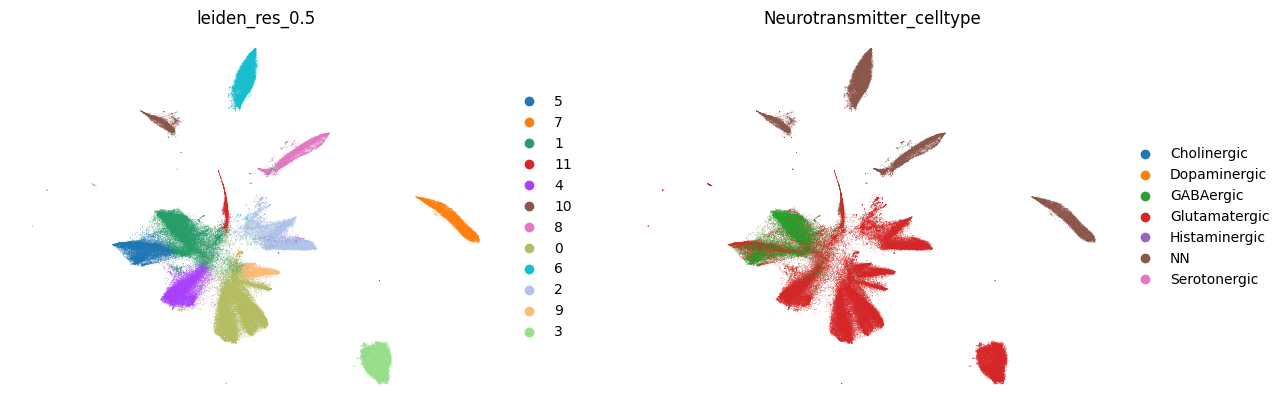

In [90]:
sc.pl.umap(adata_all,color=['leiden_res_0.5','Neurotransmitter_celltype'],frameon=False,show=False)

In [94]:
meta_atac = merged_df

In [96]:
meta_atac['Sample_name'] = meta_atac['sample']
meta_atac['Condition'] = meta_atac['Sample_name'].str[:2]
meta_atac['Region'] = meta_atac['Sample_name'].str.split('_').str[1]

In [97]:
meta_atac['Neurotransmitter_celltype'] = meta_atac['Neurotransmitter_celltype'].fillna('NN')

df_nt = meta_atac.groupby(['Sample_name','Neurotransmitter_celltype']).count()

In [98]:
df_nt

sample  doublet_probability  \
Sample_name Neurotransmitter_celltype                                
MC25A_PFC   Cholinergic                     0                    0   
            Dopaminergic                    0                    0   
            GABAergic                    1573                 1573   
            Glutamatergic               12550                12550   
            Histaminergic                   0                    0   
...                                       ...                  ...   
MW65A_AMY   GABAergic                    3110                 3110   
            Glutamatergic                2963                 2963   
            Histaminergic                   0                    0   
            NN                           1971                 1971   
            Serotonergic                    0                    0   

                                       doublet_score  leiden  leiden_default  \
Sample_name Neurotransmitter_celltype                                          
MC25A_PFC   Cholinergic                            0       0               0   
            Dopaminergic                           0       0               0   
            GABAergic                           1573    1573            1573   
            Glutamatergic                      12550   12550           12550   
            Histaminergic                          0       0               0   
...                                              ...     ...             ...   
MW65A_AMY   GABAergic                           3110    3110            3110   
            Glutamatergic                       2963    2963            2963   
            Histaminergic                          0       0               0   
            NN                                  1971    1971            1971   
            Serotonergic                           0       0               0   

                                       leiden_res_0.1  leiden_res_0.2  \
Sample_name Neurotransmitter_celltype                                   
MC25A_PFC   Cholinergic                             0               0   
            Dopaminergic                            0               0   
            GABAergic                            1573            1573   
            Glutamatergic                       12550           12550   
            Histaminergic                           0               0   
...                                               ...             ...   
MW65A_AMY   GABAergic                            3110            3110   
            Glutamatergic                        2963            2963   
            Histaminergic                           0               0   
            NN                                   1971            1971   
            Serotonergic                            0               0   

                                       leiden_res_0.3  leiden_res_0.4  \
Sample_name Neurotransmitter_celltype                                   
MC25A_PFC   Cholinergic                             0               0   
            Dopaminergic                            0               0   
            GABAergic                            1573            1573   
            Glutamatergic                       12550           12550   
            Histaminergic                           0               0   
...                                               ...             ...   
MW65A_AMY   GABAergic                            3110            3110   
            Glutamatergic                        2963            2963   
            Histaminergic                           0               0   
            NN                                   1971            1971   
            Serotonergic                            0               0   

                                       leiden_res_0.5  ...  leiden_res_1.5  \
Sample_name Neurotransmitter_celltype                  ...                   
MC25A_PFC   Cholinergic        

In [99]:
df_nt2 = df_nt.iloc[:,:1].reset_index().pivot(index='Sample_name', columns='Neurotransmitter_celltype', values='sample').reset_index().set_index('Sample_name')

In [100]:
df_nt2

Neurotransmitter_celltype,Cholinergic,Dopaminergic,GABAergic,Glutamatergic,Histaminergic,NN,Serotonergic
Sample_name,,,,,,,
MC25A_PFC,0,0,1573,12550,0,3267,0
MC37A_AMY,0,0,1870,3410,0,952,0
MC39C_HIP,0,0,459,6269,0,2194,0
MC48D_HIP,0,0,448,6427,0,2168,0
MC50B_AMY,0,0,3196,4302,0,1811,0
MC50B_HIP,0,0,267,3793,0,1329,0
MC50B_PFC,0,0,864,5143,0,2065,0
MC52E_AMY,0,0,2791,5619,0,1449,0
MC52E_PFC,0,0,731,4223,0,1944,0


In [101]:
df = pd.DataFrame(['GroupA'] * 5 + ['GroupB'] * 5, columns=['AB'])
df['CD'] = ['C'] * 3 + ['D'] * 3 + ['G'] * 4
df['EF'] = ['E'] * 6 + ['F'] * 2 + ['H'] * 2
df['F'] = np.random.normal(0, 1, 10)
df.index = ['sample' + str(i) for i in range(1, df.shape[0] + 1)]
df.head()

,AB,CD,EF,F
sample1,GroupA,C,E,-0.245932
sample2,GroupA,C,E,1.395857
sample3,GroupA,C,E,-1.425109
sample4,GroupA,D,E,0.868152
sample5,GroupA,D,E,-0.993415


Starting plotting HeatmapAnnotations


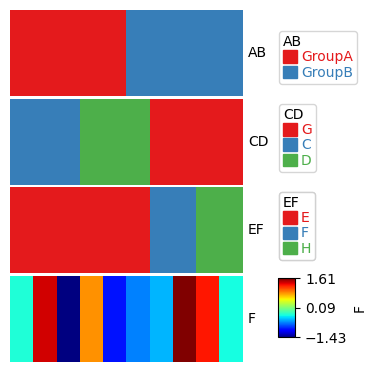

In [102]:
plt.figure(figsize=(3, 4))
col_ha = pch.HeatmapAnnotation(df=df,plot=True,legend=True,legend_gap=5,hgap=0.5,axis=1)
plt.show()


In [103]:
df_box = pd.DataFrame(np.random.randn(10, 4), columns=['Gene' + str(i) for i in range(1, 5)])
df_box.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['TMB1', 'TMB2'])
df_bar.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_scatter = pd.DataFrame(np.random.uniform(0, 10, 10), columns=['Scatter'])
df_scatter.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar1 = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['T1-A', 'T1-B'])
df_bar1.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar4 = pd.DataFrame(np.random.uniform(0, 10, (10, 1)), columns=['T4'])
df_bar4.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar4.iloc[7,0]=np.nan

Starting plotting HeatmapAnnotations


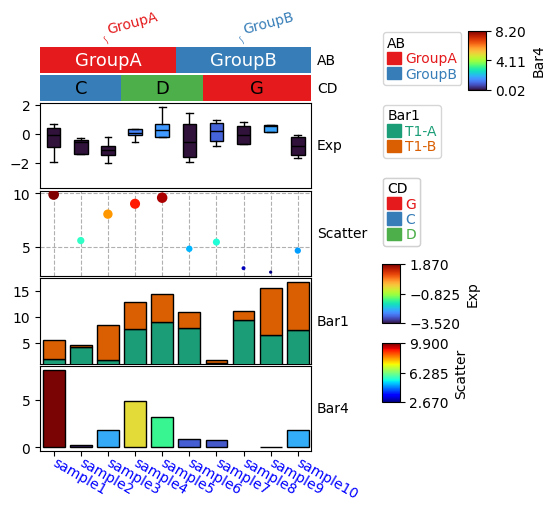

In [105]:
plt.figure(figsize=(3.5, 5))
col_ha = pch.HeatmapAnnotation(label=pch.anno_label(df.AB, merge=True,rotation=15),
                            AB=pch.anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=pch.anno_simple(df.CD, add_text=True,legend=True,text_kws={'color':'black'}),
                            Exp=pch.anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=pch.anno_scatterplot(df_scatter,grid=True),
                           Bar1=pch.anno_barplot(df_bar1,legend=True,cmap='Dark2'),
                           Bar4=pch.anno_barplot(df_bar4,legend=True,cmap='turbo'),
                           plot=True,legend=True,legend_gap=5,hgap=0.5)
col_ha.show_ticklabels(df.index.tolist(),fontdict={'color':'blue'},rotation=-30)
plt.show()


In [ ]:
# plt.figure(figsize=(30, 4))
# col_ha = pch.HeatmapAnnotation(df=meta_atac.loc[:,['Sample_name','Condition','Region']],
#                                cmap ={'Sample_name':'tab20','Condition':'Set2','Region':'Set1'},
#                                plot=True,legend=True,legend_gap=0,hgap=0.5,axis=1)

# plt.tight_layout()
# plt.show()


In [106]:
meta_atac.Condition

MC37A_AMY:AAACGAAAGAGTGGAA-1    MC
MC37A_AMY:AAACGAAAGGGTAGTC-1    MC
MC37A_AMY:AAACGAAGTACGGAGT-1    MC
MC37A_AMY:AAACGAAGTCAGCAAG-1    MC
MC37A_AMY:AAACGAAGTCCGAGCT-1    MC
                                ..
MW65A_AMY:TTTGTGTGTTCCTGTC-1    MW
MW65A_AMY:TTTGTGTTCAACGTGT-1    MW
MW65A_AMY:TTTGTGTTCATACTTC-1    MW
MW65A_AMY:TTTGTGTTCTGAGTAC-1    MW
MW65A_AMY:TTTGTGTTCTGCCGAG-1    MW
Name: Condition, Length: 176318, dtype: object

In [107]:
ntc = meta_atac.groupby(['sample','Neurotransmitter_celltype']).count()['leiden'].reset_index().pivot(index='sample', columns='Neurotransmitter_celltype', values='leiden')

In [108]:
df = meta_atac

In [109]:
cdt = meta_atac.Condition

In [110]:
summary = df.groupby(['sample', 'Neurotransmitter_celltype']).size().unstack(fill_value=0)
summary = summary.div(summary.sum(axis=1), axis=0)  # Normalize rows to proportions


In [111]:
cdt= meta_atac.loc[:,['Sample_name','Condition']].drop_duplicates(['Sample_name']).set_index('Sample_name')

In [112]:
cdt.sort_values(by='Condition', inplace=True)

In [144]:
order_cdt = cdt.index.tolist()

In [114]:
df_ntrd = df_nt2.reset_index()

In [129]:
df_ntrd = df_nt2.loc[cdt.index].loc[:,['GABAergic','Glutamatergic','NN']]

Neurotransmitter_celltype,Cholinergic,Dopaminergic,GABAergic,Glutamatergic,Histaminergic,NN,Serotonergic
Sample_name,,,,,,,
MC37A_AMY,0,0,1870,3410,0,952,0
MC39C_HIP,0,0,459,6269,0,2194,0
MC48D_HIP,0,0,448,6427,0,2168,0
MC50B_AMY,0,0,3196,4302,0,1811,0
MC50B_HIP,0,0,267,3793,0,1329,0
MC50B_PFC,0,0,864,5143,0,2065,0
MC52E_AMY,0,0,2791,5619,0,1449,0
MC52E_PFC,0,0,731,4223,0,1944,0
MC25A_PFC,0,0,1573,12550,0,3267,0


In [137]:
df_ntrd.reset_index(inplace=True)

In [138]:
dict_pro = {col: np.round(df_ntrd[col].values/df_nt2.sum(axis=1).values * 100) for col in df_ntrd.columns if col not in ['Sample_name', 'Neurotransmitter_celltype']}

In [139]:
dict_pro

{'GABAergic': array([11.,  7.,  5., 35.,  3., 16., 35.,  7., 23.,  7.,  5., 21.,  4.,
         9., 49., 20., 10., 39.]),
 'Glutamatergic': array([ 20., 101.,  72.,  48.,  41.,  95.,  70.,  43., 182.,  42.,  57.,
         31.,  61., 111.,  75., 128.,  53.,  37.]),
 'NN': array([ 5., 35., 24., 20., 14., 38., 18., 20., 47., 14., 13., 13., 25.,
        36., 29., 33., 22., 25.])}

In [132]:
df_pro = pd.DataFrame(dict_pro)

In [ ]:
df_pro.index = df_ntrd['Sample_name'].values

In [ ]:
cdt

In [ ]:
df_pro

In [ ]:
cdt.reset_index()

In [ ]:
# plt.figure(figsize=(5, 4))
# bar_anno = pch.HeatmapAnnotation(
#     TMB=pch.anno_barplot(df_bar, stacked=True, cmap='Set1', legend=True),
#     verbose=0
# )

# plt.show()


In [172]:
meta_atac['Neurotransmitter_celltype'] = meta_atac['Neurotransmitter_celltype'].astype('str')
meta_atac['celltype.L1'] = meta_atac['celltype.L1'].astype('str')
meta_atac['Sample_name'] = meta_atac['Sample_name'].astype('str')

/tmp/ipykernel_90907/1466737680.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='Sample_name', ylabel='Proportion (%)'>)

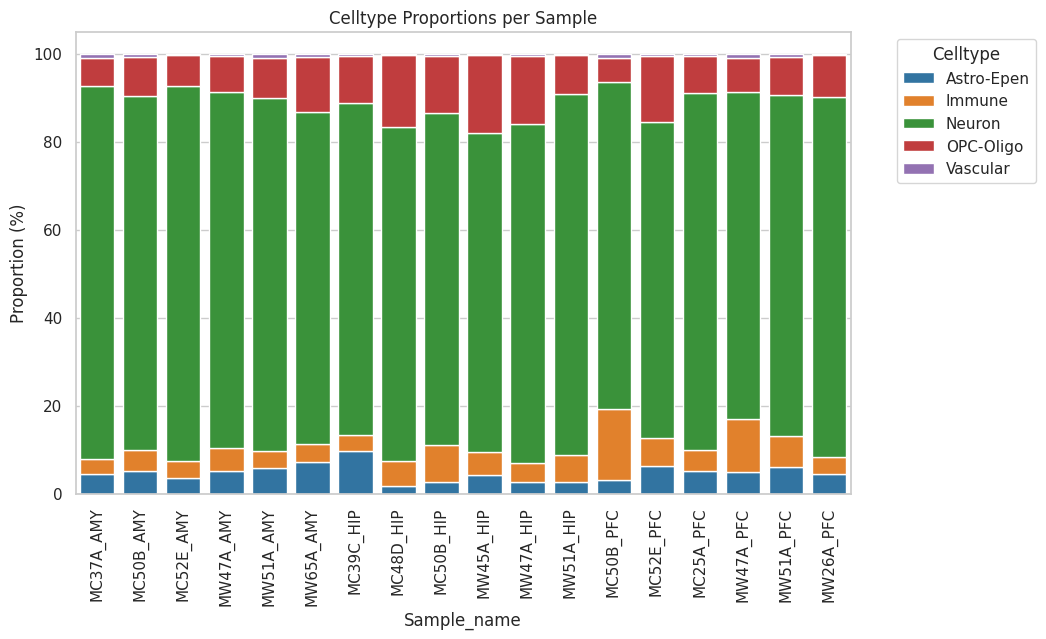

In [176]:
def plot_stack_prop(df,x=None, y='proportion',pro_col='celltype.L1',color_palette=sns.color_palette("Set2"), figsize=(10, 6),x_order=None, **kwargs):
    counts = df.groupby([x, pro_col]).size().unstack(fill_value=0)
    # If x_order is provided, sort the index of counts
    if x_order is not None:
        counts = counts.loc[x_order]
    df_prop = counts.div(counts.sum(axis=1), axis=0) * 100
    df_prop = df_prop.reset_index().melt(id_vars=x, var_name=pro_col, value_name=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")
    # Initialize bottom positions for stacking
        # Sort the dataframe by the specified order by the column of sample name
    bottom = pd.Series([0] * len(df_prop[x].unique()), index=df_prop[x].unique())
    # Plot each celltype layer
    for i, celltype in enumerate(df_prop[pro_col].unique()):
        subset = df_prop[df_prop[pro_col] == celltype]
        sns.barplot(
            x=x, y=y, data=subset,
            label=celltype, bottom=bottom[subset[x]],
            color=color_palette[i],
            dodge=False
        )
        bottom += subset.set_index(x)[y].reindex(bottom.index, fill_value=0)
    ax.set_title('Celltype Proportions per Sample')
    ax.set_ylabel('Proportion (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
    return fig,ax

order = meta_atac.sort_values(['Region','Condition'])['Sample_name'].unique()
plot_stack_prop(meta_atac,x='Sample_name',color_palette=sns.color_palette("tab10"),x_order=order, figsize=(10, 6))

Starting plotting HeatmapAnnotations


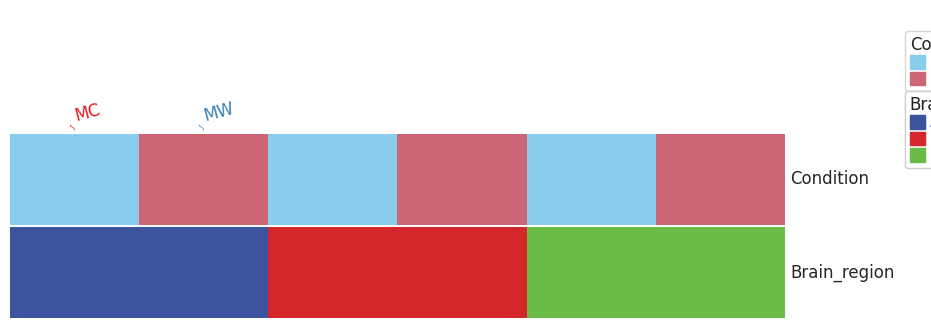

In [177]:
cdt= cdt.loc[order]

br= meta_atac.loc[:,['Sample_name','Region']].drop_duplicates(['Sample_name']).set_index('Sample_name')
plt.figure(figsize=(10, 4))
col_ha = pch.HeatmapAnnotation(
                                label=pch.anno_label(cdt.Condition, merge=True,rotation=15),
                                #Sample_name=pch.anno_simple(ntc.reset_index()['sample'],legend=True), axis=1,

                                 #Sample_name=pch.anno_simple(meta_atac.Sample_name,add_text=True,legend=True),
                                Condition=pch.anno_simple(cdt.Condition, add_text=False,legend=True,text_kws={'color':'black'},cmap='Safe'),
                                Brain_region=pch.anno_simple(br.Region, add_text=False,legend=True,text_kws={'color':'black'},cmap='nature6_2'),

                            #    pro=pch.anno_barplot(df=df_pro.iloc[:,1:],legend=True,cmap='tab10',stacked=True),
                               plot=True,legend=True,legend_gap=0,hgap=0.5)
plt.show()


/tmp/ipykernel_90907/1466737680.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='Sample_name', ylabel='Proportion (%)'>)

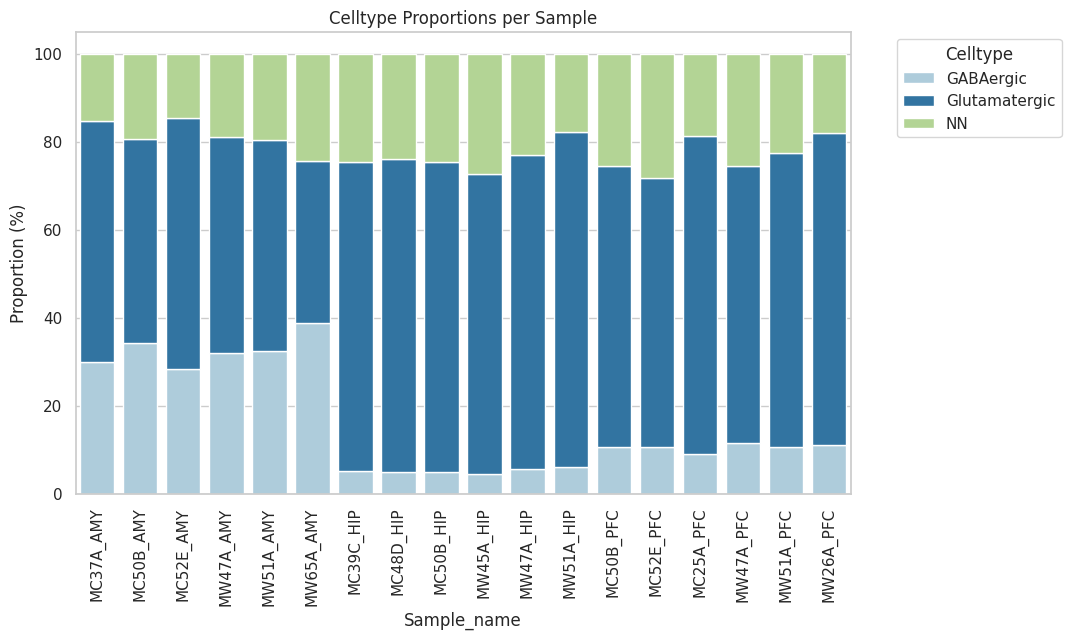

In [178]:
plot_stack_prop(meta_atac,x='Sample_name',pro_col='Neurotransmitter_celltype', y='proportion',color_palette=sns.color_palette("Paired"),x_order=order, figsize=(10, 6))

In [179]:
colors = np.random.rand(50, 3)  # 50 colors, each with RGB values
from matplotlib.colors import ListedColormap

# Create a ListedColormap
cmap = ListedColormap(colors)


In [ ]:
# df_marker = pd.read_excel("/data2st1/junyi/output/atac0416/20250423maker list.xlsx")

In [ ]:
# df_all_meta = pd.DataFrame()

# for region in meta_atac['Region'].unique():
#     df_neu = pd.read_csv(f'/data2st1/junyi/output/atac0416/ATACSC_{region}_Neuron_L2annoated.csv', index_col=0)  

#     df_region_marker = df_marker[df_marker['region'] == region]

#     if region == 'PFC':
#         df_neu['celltype.L2'] = "PFC " + df_neu['celltype.L2']
 
#     df_neu_merge = df_neu.merge(df_region_marker, left_on='celltype.L2',right_on='celltype.L2', how='left')
#     df_neu_merge.index = df_neu.index

    
#     if len(df_all_meta) > 0:
#         df_all_meta = pd.concat([df_all_meta, df_neu_merge], axis=0)
#     else:
#         df_all_meta = df_neu_merge

# df_all_meta.index = df_all_meta.index.str.replace('_query', '')

In [ ]:
# df_all_meta

In [ ]:
# adata_all.obs['celltype.L2']=adata_all.obs['celltype.L1'].astype(str)
# adata_all.obs['region'] = adata_all.obs['sample'].str.split('_').str[1]
# adata_all.obs['Neurotransmitter_celltype'] = 'NN'


In [ ]:
# adata_all.obs.loc[df_all_meta.index,'celltype.L2'] = df_all_meta['celltype.L2'].astype(str)

# adata_all.obs.loc[df_all_meta.index,'Neurotransmitter_celltype'] = df_all_meta['Neurotransmitter_celltype'].astype(str)

# adata_all.obs['region_nt'] = adata_all.obs['region'].astype(str) +"_"+ adata_all.obs['Neurotransmitter_celltype'].str[:4].astype(str)
# adata_all.obs.loc[adata_all.obs['region_nt'].str.contains('NN'),'region_nt'] = "NN"
# adata_all.obs.loc[adata_all.obs['region_nt'].str.contains('nan'),'region_nt'] = np.nan

In [185]:
adata_all.obs['region_nt'] = adata_all.obs['Region'].astype(str) + "_" + adata_all.obs['Neurotransmitter_celltype'].str[:4].astype(str)
adata_all.obs.loc[adata_all.obs['region_nt'].str.contains('NN'),'region_nt'] = "NN"

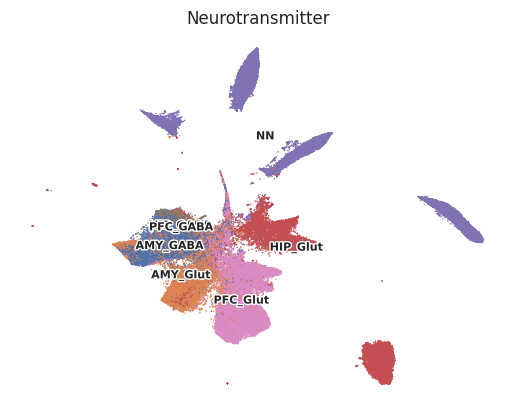

In [194]:
sc.pl.umap(adata_all, color=['region_nt'], size=5, legend_fontsize=8, title='Neurotransmitter', frameon=False, show=True,legend_loc='on data', 
           legend_fontoutline=2,save='01_umap_3region.svg',)

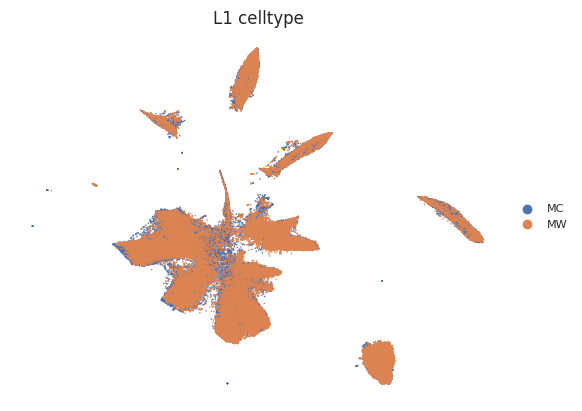

In [199]:
sc.pl.umap(adata_all, color=['Condition'], size=5, legend_fontsize=8, title='L1 celltype', frameon=False, show=True, 
           legend_fontoutline=2,save='01_umap_3region.svg',cmap=cmap)

In [187]:
adata_all.obs.to_csv('/home/junyichen/code/scmmd/output/atac0416/ATACSC_3REGION_ALL_L2annoated.csv')